# Segmenting and Clustering Neighborhoods in Toronto

This notebook is dedicated to the assignment with the above name in the Data Science Professional Certificate course. This assignment is a preparatory for the Capstone Project.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geocoder
import folium
import utils
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
plt.style.use('ggplot')

### Part I: Prepare Data

In [2]:
wiki_tables = pd.read_html('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M')

In [3]:
wiki_tables[0]

,Postcode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
...,...,...,...
282,M8Z,Etobicoke,Mimico NW
283,M8Z,Etobicoke,The Queensway West
284,M8Z,Etobicoke,Royal York South West
285,M8Z,Etobicoke,South of Bloor


This is the target table.

In [4]:
df = wiki_tables[0]

Remove cells that have a "Not assigned" borough.

In [5]:
df = df[df['Borough'] != 'Not assigned']

In [6]:
df.head()

,Postcode,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M6A,North York,Lawrence Heights
6,M6A,North York,Lawrence Manor


Merge rows that correspond to the same postcode.

In [7]:
df = df.groupby(['Postcode', 'Borough'])['Neighbourhood'].apply(', '.join).reset_index()

In [8]:
df[df['Postcode'] == 'M6A']

,Postcode,Borough,Neighbourhood
71,M6A,North York,"Lawrence Heights, Lawrence Manor"


Assign borough's name to the neighborhood if the neighborhood is not assigned.

In [9]:
df[df['Neighbourhood'] == 'Not assigned']

,Postcode,Borough,Neighbourhood
93,M9A,Queen's Park,Not assigned


In [10]:
df['Neighbourhood'] = np.where(df['Neighbourhood'] == 'Not assigned', df['Borough'], df['Neighbourhood'])

In [11]:
df[df['Postcode'] == 'M9A']

,Postcode,Borough,Neighbourhood
93,M9A,Queen's Park,Queen's Park


Print shape of the cleaned dataframe.

In [12]:
df.shape

(103, 3)

### Part II: Extract Coordinates

Use below to get the coordinates using geocoder library. This package is unreliable and did not work for me.

In [13]:
"""
for index, row in df.iterrows():
    lat_lng_coords = None
    postal_code = row['Postcode']
    
    while lat_lng_coords is None:
        g = geocoder.google(f'{postal_code}, Toronto, Ontario')
        lat_lng_coords = g.latlng
        
    latitude = lat_lng_coords[0]
    longitude = lat_lng_coords[1]
    
    df.loc[index, 'Latitude'] = latitude
    df.loc[index, 'Longitude'] = longitude
    
    if (index % 9) == 0:
        print('10 rows processed')
"""

"\nfor index, row in df.iterrows():\n    lat_lng_coords = None\n    postal_code = row['Postcode']\n    \n    while lat_lng_coords is None:\n        g = geocoder.google(f'{postal_code}, Toronto, Ontario')\n        lat_lng_coords = g.latlng\n        \n    latitude = lat_lng_coords[0]\n    longitude = lat_lng_coords[1]\n    \n    df.loc[index, 'Latitude'] = latitude\n    df.loc[index, 'Longitude'] = longitude\n    \n    if (index % 9) == 0:\n        print('10 rows processed')\n"

Extract coordinates using a csv with the data.

In [14]:
df_coord = pd.read_csv('../data/Geospatial_Coordinates.csv')

In [15]:
df_coord.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [16]:
df_coord.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103 entries, 0 to 102
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Postal Code  103 non-null    object 
 1   Latitude     103 non-null    float64
 2   Longitude    103 non-null    float64
dtypes: float64(2), object(1)
memory usage: 2.5+ KB


In [17]:
df = df.merge(df_coord, left_on='Postcode', right_on='Postal Code')

In [18]:
df.head()

,Postcode,Borough,Neighbourhood,Postal Code,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",M1B,43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",M1C,43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",M1E,43.763573,-79.188711
3,M1G,Scarborough,Woburn,M1G,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,M1H,43.773136,-79.239476


In [19]:
df.drop(columns='Postal Code', inplace=True)

In [20]:
df.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


### Part III: Cluster Toronto Neighborhoods

Coordinates of Toronto (got them manually by doing a Google search):

In [21]:
toronto_lat = 43.6532
toronto_lng = -79.3832

Filter Toronto neighborhoods.

In [22]:
df_tor = df[df['Borough'].str.contains('Toronto')]

In [23]:
df_tor.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude
37,M4E,East Toronto,The Beaches,43.676357,-79.293031
41,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188
42,M4L,East Toronto,"The Beaches West, India Bazaar",43.668999,-79.315572
43,M4M,East Toronto,Studio District,43.659526,-79.340923
44,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790


In [24]:
df_tor.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39 entries, 37 to 87
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Postcode       39 non-null     object 
 1   Borough        39 non-null     object 
 2   Neighbourhood  39 non-null     object 
 3   Latitude       39 non-null     float64
 4   Longitude      39 non-null     float64
dtypes: float64(2), object(3)
memory usage: 1.8+ KB


Plot Toronto map with neighborhoods.

In [25]:
map_toronto = folium.Map(location=[toronto_lat, toronto_lng], zoom_start=12)

for lat, lng, borough, neighborhood in zip(df_tor['Latitude'], df_tor['Longitude'], df_tor['Borough'], df_tor['Neighbourhood']):
    label = f'{neighborhood}, {borough}'
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
    [lat, lng],
    radius=5,
    popup=label,
    color='blue',
    fill=True,
    fill_color='#3186cc',
    fill_opacity=0.7,
    parse_html=False).add_to(map_toronto)
    
map_toronto

Get Toronto venues for each neighborhood using the Foursquare API. See the function in utils.py for details.

In [26]:
# Add Foursquare API key, secret and version to utils.py for this to work
toronto_venues = utils.get_nearby_venues(names=df_tor['Neighbourhood'],
                                         latitudes=df_tor['Latitude'],
                                         longitudes=df_tor['Longitude'])

The Beaches
The Danforth West, Riverdale
The Beaches West, India Bazaar
Studio District
Lawrence Park
Davisville North
North Toronto West
Davisville
Moore Park, Summerhill East
Deer Park, Forest Hill SE, Rathnelly, South Hill, Summerhill West
Rosedale
Cabbagetown, St. James Town
Church and Wellesley
Harbourfront
Ryerson, Garden District
St. James Town
Berczy Park
Central Bay Street
Adelaide, King, Richmond
Harbourfront East, Toronto Islands, Union Station
Design Exchange, Toronto Dominion Centre
Commerce Court, Victoria Hotel
Roselawn
Forest Hill North, Forest Hill West
The Annex, North Midtown, Yorkville
Harbord, University of Toronto
Chinatown, Grange Park, Kensington Market
CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara
Stn A PO Boxes 25 The Esplanade
First Canadian Place, Underground city
Christie
Dovercourt Village, Dufferin
Little Portugal, Trinity
Brockton, Exhibition Place, Parkdale Village
High Park, The Junction Sout

In [27]:
toronto_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,The Beaches,43.676357,-79.293031,Glen Manor Ravine,43.676821,-79.293942,Trail
1,The Beaches,43.676357,-79.293031,The Big Carrot Natural Food Market,43.678879,-79.297734,Health Food Store
2,The Beaches,43.676357,-79.293031,Grover Pub and Grub,43.679181,-79.297215,Pub
3,The Beaches,43.676357,-79.293031,Glen Stewart Park,43.675278,-79.294647,Park
4,The Beaches,43.676357,-79.293031,Upper Beaches,43.680563,-79.292869,Neighborhood


In [28]:
toronto_venues.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1192 entries, 0 to 1191
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Neighborhood            1192 non-null   object 
 1   Neighborhood Latitude   1192 non-null   float64
 2   Neighborhood Longitude  1192 non-null   float64
 3   Venue                   1192 non-null   object 
 4   Venue Latitude          1192 non-null   float64
 5   Venue Longitude         1192 non-null   float64
 6   Venue Category          1192 non-null   object 
dtypes: float64(4), object(3)
memory usage: 65.3+ KB


Perform one-hot-encoding by venue category. This is to be used for clustering later on.

In [29]:
# One hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# Add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# Move neighborhood column to the first column
neighborhood = toronto_onehot['Neighborhood']
toronto_onehot.drop(columns='Neighborhood', inplace=True)
toronto_onehot.insert(0, 'Neighborhood', neighborhood)

toronto_onehot.head()

,Neighborhood,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,...,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Yoga Studio
0,The Beaches,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,The Beaches,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,The Beaches,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,The Beaches,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,The Beaches,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
toronto_onehot.shape

(1192, 210)

Get the mean of each venue category per neighborhood.

In [31]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()

In [32]:
toronto_grouped.head()

,Neighborhood,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,...,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Yoga Studio
0,"Adelaide, King, Richmond",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.04,0.0,0.0,...,0.0,0.0,0.0,0.0,0.02,0.0,0.0,0.0,0.0,0.000000
1,Berczy Park,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.02,0.0,0.0,0.0,0.0,0.000000
2,"Brockton, Exhibition Place, Parkdale Village",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.043478
3,Business Reply Mail Processing Centre 969 Eastern,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.052632
4,"CN Tower, Bathurst Quay, Island airport, Harbo...",0.058824,0.058824,0.058824,0.117647,0.176471,0.117647,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.000000


Take top 10 venue categories for each neighborhood and sort by mean. See the function in utils.py for additional details.

In [33]:
toronto_venues_sorted = utils.sort_neighborhood_venues(toronto_grouped)

In [34]:
toronto_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, King, Richmond",Steakhouse,Café,Hotel,Seafood Restaurant,Coffee Shop,Gastropub,American Restaurant,Pizza Place,Asian Restaurant,Jazz Club
1,Berczy Park,Coffee Shop,Cocktail Bar,Seafood Restaurant,Steakhouse,Beer Bar,Farmers Market,Bakery,Cheese Shop,Café,Italian Restaurant
2,"Brockton, Exhibition Place, Parkdale Village",Café,Performing Arts Venue,Breakfast Spot,Coffee Shop,Yoga Studio,Climbing Gym,Burrito Place,Restaurant,Italian Restaurant,Stadium
3,Business Reply Mail Processing Centre 969 Eastern,Light Rail Station,Yoga Studio,Auto Workshop,Comic Shop,Pizza Place,Recording Studio,Restaurant,Burrito Place,Brewery,Skate Park
4,"CN Tower, Bathurst Quay, Island airport, Harbo...",Airport Service,Airport Lounge,Airport Terminal,Airport,Harbor / Marina,Plane,Coffee Shop,Sculpture Garden,Boat or Ferry,Bar


Perform clustering on the neighborhoods. First, identify the number of clusters to be used with the elbow method.

In [35]:
X = toronto_grouped.drop(columns=['Neighborhood'])

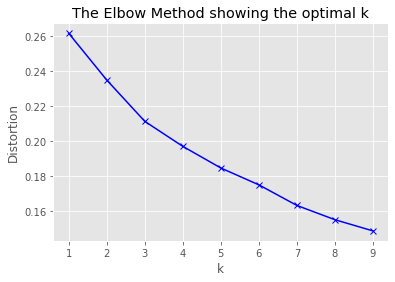

In [36]:
# Drawing inspiration from https://pythonprogramminglanguage.com/kmeans-elbow-method/

distortions = []
K = range(1,10)
for k in K:
    kmeans = KMeans(n_clusters=k, n_init=50).fit(X)
    kmeans.fit(X)
    distortions.append(sum(np.min(cdist(X, kmeans.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

The elbow method is not obvious here at all. There seems to be slight changes to slope starting with 3 clusters, so let's use that. That's also a decent number of clusters to analyze manually later on.

In [37]:
kclusters = 3
kmeans = KMeans(n_clusters=kclusters, n_init=50, random_state=42)
kmeans = kmeans.fit(X)

In [38]:
toronto_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [39]:
toronto_merged = df_tor.merge(toronto_venues_sorted, left_on='Neighbourhood', right_on='Neighborhood').drop(columns='Neighbourhood')

In [40]:
toronto_merged.head()

,Postcode,Borough,Latitude,Longitude,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M4E,East Toronto,43.676357,-79.293031,1,The Beaches,Park,Trail,Health Food Store,Pub,Yoga Studio,Cupcake Shop,Eastern European Restaurant,Dumpling Restaurant,Doner Restaurant,Dog Run
1,M4K,East Toronto,43.679557,-79.352188,0,"The Danforth West, Riverdale",Greek Restaurant,Italian Restaurant,Coffee Shop,Bookstore,Ice Cream Shop,Furniture / Home Store,Fruit & Vegetable Store,Pub,Pizza Place,Liquor Store
2,M4L,East Toronto,43.668999,-79.315572,0,"The Beaches West, India Bazaar",Park,Liquor Store,Movie Theater,Ice Cream Shop,Sushi Restaurant,Fish & Chips Shop,Brewery,Pub,Italian Restaurant,Fast Food Restaurant
3,M4M,East Toronto,43.659526,-79.340923,0,Studio District,Café,Coffee Shop,Brewery,Bakery,Italian Restaurant,American Restaurant,Gastropub,Park,Sandwich Place,Cheese Shop
4,M4N,Central Toronto,43.728020,-79.388790,1,Lawrence Park,Photography Studio,Park,Swim School,Bus Line,Deli / Bodega,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Doner Restaurant,Dog Run


Plot neighborhoods colored by the corresponding cluster they were assigned to.

In [41]:
map_clusters = folium.Map(location=[toronto_lat, toronto_lng], zoom_start=12)

colors = ['darkred', 'green', 'darkblue']

for lat, lon, neighborhood, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(neighborhood) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
    [lat, lon],
    radius=5,
    popup=label,
    color=colors[cluster],
    fill=True,
    fill_color=colors[cluster],
    fill_opacity=0.7).add_to(map_clusters)
    
map_clusters